In [7]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import warnings
import seaborn as sns

warnings.filterwarnings("ignore")
os.chdir("/Users/yj.noh/Documents/GitHub")
print(os.getcwd())
plt.rcParams['font.family'] = 'AppleGothic'

/Users/yj.noh/Documents/GitHub


In [5]:
data = pd.read_excel("/Users/yj.noh/Desktop/new_rider_need_rgn.xlsx")
print(data.head(2))
print(data.isna().sum())
print(data.shape)

     base_day rgn1_nm::filter  rgn2_nm    r_value    dr_value  \
0  2023-10-12            경상남도  창원시 의창구  24.840764   15.941538   
1  2023-10-31             경기도  성남시 중원구  27.771619  114.145309   

   rider_cnt_within_28days  rider_cnt  dlvry_cnt  avg_consign_min  \
0                      314         78      396.0         4.100084   
1                     1804        501     3170.0         2.471094   

   baemin1_single_limited_time  weather_fee  
0                          0.0          0.0  
1                          0.0          0.0  
base_day                         0
rgn1_nm::filter                  0
rgn2_nm                          0
r_value                          0
dr_value                       128
rider_cnt_within_28days          0
rider_cnt                        0
dlvry_cnt                      128
avg_consign_min                128
baemin1_single_limited_time    148
weather_fee                    130
dtype: int64
(8993, 11)


In [6]:
data = data[data['dr_value'].notnull()]
print(data.shape) #8,865 

(8865, 11)


<Axes: ylabel='r_value'>

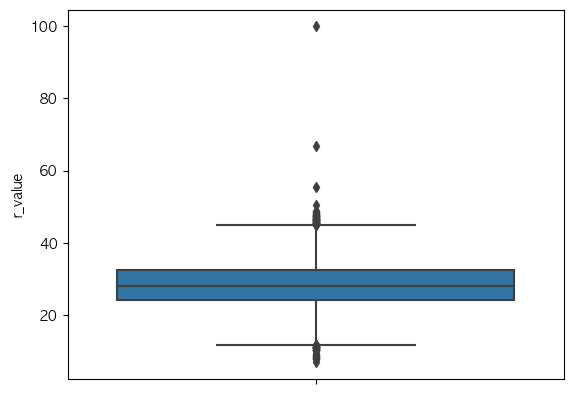

In [10]:
sns.boxplot(y = data['r_value'], data =data)

In [ ]:
def plot_numeric (data, numeric_vars, outcome):
    
    palette = 'coolwarm'
    
    for num_var in numeric_vars:
        fig, axs = plt.subplots(1,3, figsize=(12,4))
        fig.suptitle(f'{num_var}', fontsize = 12)
    
        # Boxplot
        sns.boxplot(ax=axs[0], x= outcome, y=num_var, data= data, palette = palette)
        axs[0].set_title('Boxplot')
    
        # Violinplot
        sns.violinplot(ax=axs[1], x = outcome, y = num_var, data = data, palette = palette)
        axs[1].set_title('Violinplot')
        
        # KDE plot
        sns.kdeplot(ax=axs[2], data = data, x = num_var, hue = outcome, fill = True, common_norm = False, palette = palette, alpha=.5, linewidth=0)
        axs[2].set_title('Density plot')
        
        plt.tight_layout()
        fig.subplots_adjust(top=0.8) # title 공간 확보
        
        plt.show()
        plt.close(fig)

In [19]:
median_rvalue = data.groupby('rgn2_nm')['r_value'].median()
mean_rvalue = data.groupby('rgn2_nm')['r_value'].mean()
std_rvalue = data.groupby('rgn2_nm')['r_value'].std()

table = pd.concat([median_rvalue, mean_rvalue, std_rvalue], keys = ['median', 'mean', 'std'],  axis = 1)
print(table)


            median       mean       std
rgn2_nm                                
강남구      36.901448  36.848465  1.681972
강동구      30.616175  31.643985  2.675382
강릉시      37.500000  37.422775  3.655884
강북구      28.591451  28.499372  2.297986
강서구      29.316822  28.063628  6.389687
...            ...        ...       ...
포항시 남구   37.055838  36.946797  2.808694
포항시 북구   39.545455  39.584209  3.308134
하남시      25.216522  26.083332  2.646290
해운대구     26.568266  27.133550  2.162392
화성시      28.180473  28.519965  2.319751

[127 rows x 3 columns]
